In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib widget

Index(['% Time (s)', ' Channel A (Input 1) (V)'], dtype='object')


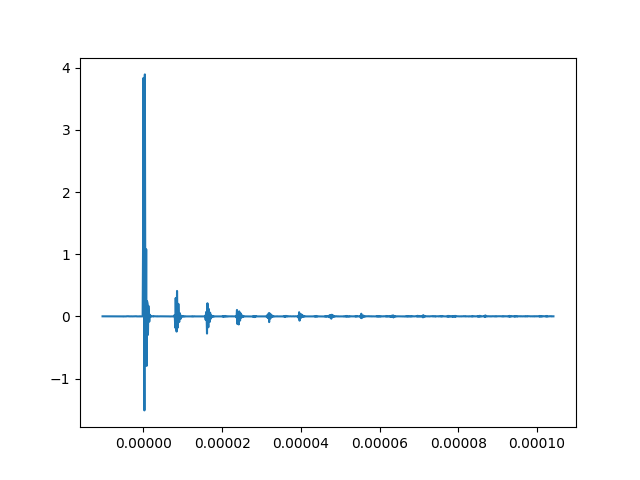

In [4]:
measures = 'measures2/petits_cylindres_alu_full_train_20230928_100512_Traces.csv'

first_measure = pd.read_csv(measures, header = 9)
fig, ax = plt.subplots()
print(first_measure.columns)
ax.plot(first_measure[first_measure.columns[0]], first_measure[first_measure.columns[1]])

[]
